In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch
import gc
import os
import imageio
import yaml
from torch.optim import Adam
from datetime import datetime
from PIL import Image
import requests

## 2D Gaussian Splatting ##

The core function for generating 2D Gaussian Splatting. The core mechanic of this function is as follow

> Constructs a 2D Gaussian kernel using provided batch of sigma_x, sigma_y, and rho
\begin{equation} \sigma_x, \sigma_y, \rho\ \end{equation}


> Normalises and reshapes the kernel to RGB channels, pads to match the image size, and translates based on given coords. Basically poutting the relevant kernel in the relevant coordinate position.


> Multiplies the RGB kernels with given colours, sums up the layers, and returns the final clamped and permuted image.







In [2]:
def generate_2D_gaussian_splatting(kernel_size, sigma_x, sigma_y, rho, coords, colours, image_size=(256, 256, 3), device="cuda"):

    batch_size = colours.shape[0]

    sigma_x = sigma_x.view(batch_size, 1, 1)
    sigma_y = sigma_y.view(batch_size, 1, 1)
    rho = rho.view(batch_size, 1, 1)

    covariance = torch.stack(
        [torch.stack([sigma_x**2, rho*sigma_x*sigma_y], dim=-1),
        torch.stack([rho*sigma_x*sigma_y, sigma_y**2], dim=-1)],
        dim=-2
    )

    # Check for positive semi-definiteness
    determinant = (sigma_x**2) * (sigma_y**2) - (rho * sigma_x * sigma_y)**2
    if (determinant <= 0).any():
        raise ValueError("Covariance matrix must be positive semi-definite")

    inv_covariance = torch.inverse(covariance)

    # Choosing quite a broad range for the distribution [-5,5] to avoid any clipping
    start = torch.tensor([-5.0], device=device).view(-1, 1)
    end = torch.tensor([5.0], device=device).view(-1, 1)
    base_linspace = torch.linspace(0, 1, steps=kernel_size, device=device)
    ax_batch = start + (end - start) * base_linspace

    # Expanding dims for broadcasting
    ax_batch_expanded_x = ax_batch.unsqueeze(-1).expand(-1, -1, kernel_size)
    ax_batch_expanded_y = ax_batch.unsqueeze(1).expand(-1, kernel_size, -1)

    # Creating a batch-wise meshgrid using broadcasting
    xx, yy = ax_batch_expanded_x, ax_batch_expanded_y

    xy = torch.stack([xx, yy], dim=-1)
    z = torch.einsum('b...i,b...ij,b...j->b...', xy, -0.5 * inv_covariance, xy)
    kernel = torch.exp(z) / (2 * torch.tensor(np.pi, device=device) * torch.sqrt(torch.det(covariance)).view(batch_size, 1, 1))


    kernel_max_1, _ = kernel.max(dim=-1, keepdim=True)  # Find max along the last dimension
    kernel_max_2, _ = kernel_max_1.max(dim=-2, keepdim=True)  # Find max along the second-to-last dimension
    kernel_normalized = kernel / kernel_max_2

    kernel_reshaped = kernel_normalized.repeat(1, 3, 1).view(batch_size * 3, kernel_size, kernel_size)
    kernel_rgb = kernel_reshaped.unsqueeze(0).reshape(batch_size, 3, kernel_size, kernel_size)

    # Calculating the padding needed to match the image size
    pad_h = image_size[0] - kernel_size
    pad_w = image_size[1] - kernel_size

    if pad_h < 0 or pad_w < 0:
        raise ValueError("Kernel size should be smaller or equal to the image size.")

    # Adding padding to make kernel size equal to the image size
    padding = (pad_w // 2, pad_w // 2 + pad_w % 2,  # padding left and right
               pad_h // 2, pad_h // 2 + pad_h % 2)  # padding top and bottom

    kernel_rgb_padded = torch.nn.functional.pad(kernel_rgb, padding, "constant", 0)

    # Extracting shape information
    b, c, h, w = kernel_rgb_padded.shape

    # Create a batch of 2D affine matrices
    theta = torch.zeros(b, 2, 3, dtype=torch.float32, device=device)
    theta[:, 0, 0] = 1.0
    theta[:, 1, 1] = 1.0
    theta[:, :, 2] = coords

    # Creating grid and performing grid sampling
    grid = F.affine_grid(theta, size=(b, c, h, w), align_corners=True)
    kernel_rgb_padded_translated = F.grid_sample(kernel_rgb_padded, grid, align_corners=True)

    rgb_values_reshaped = colours.unsqueeze(-1).unsqueeze(-1)

    final_image_layers = rgb_values_reshaped * kernel_rgb_padded_translated
    final_image = final_image_layers.sum(dim=0)
    final_image = torch.clamp(final_image, 0, 1)
    final_image = final_image.permute(1,2,0)

    return final_image


# Example usage

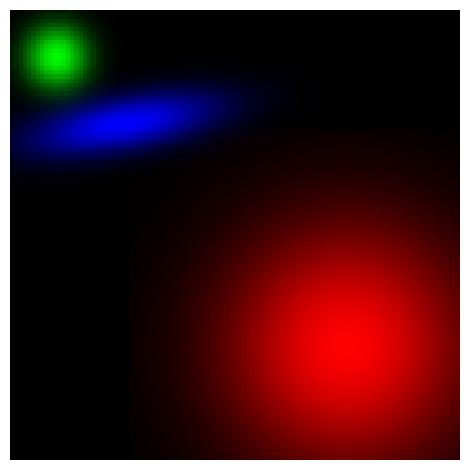

In [3]:
device = "cuda"
kernel_size = 101  # You can adjust the kernel size as needed
rho = torch.tensor([0.0, 0.0, -0.5], device=device)
sigma_x = torch.tensor([2.0, 0.5, 0.5], device=device)
sigma_y = torch.tensor([2.0, 0.5, 1.5], device=device)
vectors = torch.tensor([(-0.5, -0.5), (0.8, 0.8), (0.5, 0.5)], device=device)
colours = torch.tensor([(1.0, 0.0, 0.0), (0.0, 1.0, 0.0), (0.0, 0.0, 1.0)], device=device)
img_size = (105, 105, 3)

final_image = generate_2D_gaussian_splatting(kernel_size, sigma_x, sigma_y, rho, vectors, colours, img_size, device=device)

plt.imshow(final_image.detach().cpu().numpy())
plt.axis("off")
plt.tight_layout()
plt.show()

## Structural Similarity Index (SSIM) ##
This function calculates the combined loss by taking the weighted sum of L1 (mean absolute error) loss and the SSIM-based loss, controlled by lambda_param. This approach might be used to balance the importance of pixel-level accuracy (L1) and perceptual quality (SSIM) in the training of neural networks.

In [4]:
def create_window(window_size, channel):
    def gaussian(window_size, sigma):
        gauss = torch.exp(torch.tensor([-(x - window_size//2)**2/float(2*sigma**2) for x in range(window_size)]))
        return gauss/gauss.sum()

    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.autograd.Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())

    return window



def ssim(img1, img2, window_size=11, size_average=True):


    # Assuming the image is of shape [N, C, H, W]
    (_, _, channel) = img1.size()

    img1 = img1.unsqueeze(0).permute(0, 3, 1, 2)
    img2 = img2.unsqueeze(0).permute(0, 3, 1, 2)


    # Parameters for SSIM
    C1 = 0.01**2
    C2 = 0.03**2

    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding=window_size//2, groups=channel) - mu1_mu2

    SSIM_numerator = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))
    SSIM_denominator = ((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    SSIM = SSIM_numerator / SSIM_denominator

    return torch.clamp((1 - SSIM) / 2, 0, 1)

def d_ssim_loss(img1, img2, window_size=11, size_average=True):
    return ssim(img1, img2, window_size, size_average).mean()

# Combined Loss
def combined_loss(pred, target, lambda_param=0.5):
    l1loss = nn.L1Loss()
    return (1 - lambda_param) * l1loss(pred, target) + lambda_param * d_ssim_loss(pred, target)

## Download Data ##
This is mainly to make sure the config and image file exist and downloaded from the repository especially if you running it on colab

In [5]:
url1 = 'https://raw.githubusercontent.com/OutofAi/2D-Gaussian-Splatting/main/Image-01.png'
filename1 = url1.split('/')[-1]
response1 = requests.get(url1)
with open(filename1, 'wb') as f:
    f.write(response1.content)

url2 = 'https://raw.githubusercontent.com/OutofAi/2D-Gaussian-Splatting/main/config.yml'
filename2 = url2.split('/')[-1]
response2 = requests.get(url2)
with open(filename2, 'wb') as f:
    f.write(response2.content)


## Load Config ##

In [6]:
# Read the config.yml file
with open('config.yml', 'r') as config_file:
    config = yaml.safe_load(config_file)

# Extract values from the loaded config
KERNEL_SIZE = config["KERNEL_SIZE"]
image_size = tuple(config["image_size"])
primary_samples = config["primary_samples"]
backup_samples = config["backup_samples"]
num_epochs = config["num_epochs"]
densification_interval = config["densification_interval"]
learning_rate = config["learning_rate"]
image_file_name = config["image_file_name"]
display_interval = config["display_interval"]
grad_threshold = config["gradient_threshold"]
gauss_threshold = config["gaussian_threshold"]
display_loss = config["display_loss"]


## Prepate the points ##

In [7]:
def give_required_data(input_coords, image_size):

  # normalising pixel coordinates [-1,1]
  coords = torch.tensor(input_coords / [image_size[0],image_size[1]], device=device).float()
  center_coords_normalized = torch.tensor([0.5, 0.5], device=device).float()
  coords = (center_coords_normalized - coords) * 2.0

  # Fetching the colour of the pixels in each coordinates
  colour_values = [image_array[coord[1], coord[0]] for coord in input_coords]
  colour_values_np = np.array(colour_values)
  colour_values_tensor =  torch.tensor(colour_values_np, device=device).float()

  return colour_values_tensor, coords

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_samples = primary_samples + backup_samples

PADDING = KERNEL_SIZE // 2
image_path = image_file_name
original_image = Image.open(image_path)
original_image = original_image.resize((image_size[0],image_size[0]))
original_image = original_image.convert('RGB')
original_array = np.array(original_image)
original_array = original_array / 255.0
width, height, _ = original_array.shape

image_array = original_array
target_tensor = torch.tensor(image_array, dtype=torch.float32, device=device)
coords = np.random.randint(0, [width, height], size=(num_samples, 2))
random_pixel_means = torch.tensor(coords, device=device)
pixels = [image_array[coord[0], coord[1]] for coord in coords]
pixels_np = np.array(pixels)
random_pixels =  torch.tensor(pixels_np, device=device)

colour_values, pixel_coords = give_required_data(coords, image_size)

pixel_coords = torch.atanh(pixel_coords)

sigma_values = torch.rand(num_samples, 2, device=device)
rho_values = 2 * torch.rand(num_samples, 1, device=device) - 1
alpha_values = torch.ones(num_samples, 1, device=device)
W_values = torch.cat([sigma_values, rho_values, alpha_values, colour_values, pixel_coords], dim=1)


In [9]:
starting_size = primary_samples
left_over_size = backup_samples
persistent_mask = torch.cat([torch.ones(starting_size, dtype=bool),torch.zeros(left_over_size, dtype=bool)], dim=0)
current_marker = starting_size

In [10]:
# Get current date and time as string
now = datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

# Create a directory with the current date and time as its name
directory = f"{now}"
os.makedirs(directory, exist_ok=True)

In [11]:
W = nn.Parameter(W_values)
optimizer = Adam([W], lr=learning_rate)
loss_history = []

## Training Loop ##

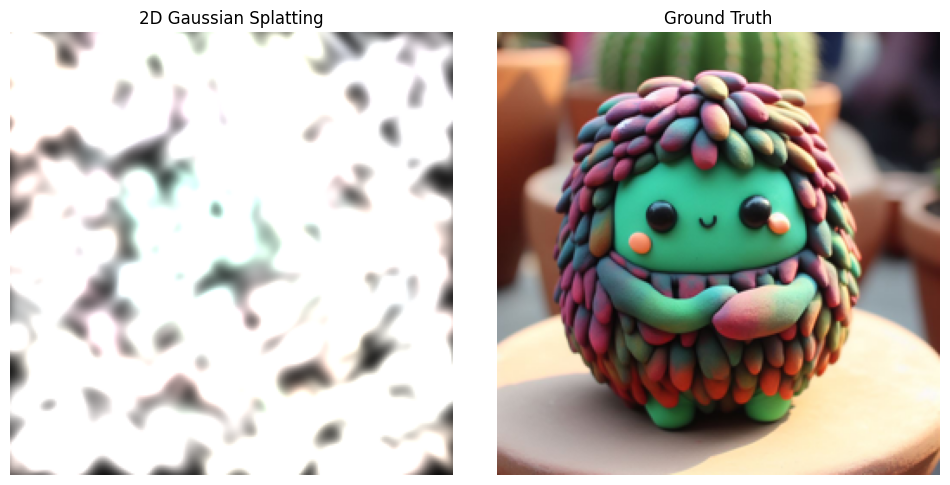

Epoch 1/2001, Loss: 0.45646485686302185, on 1000 points


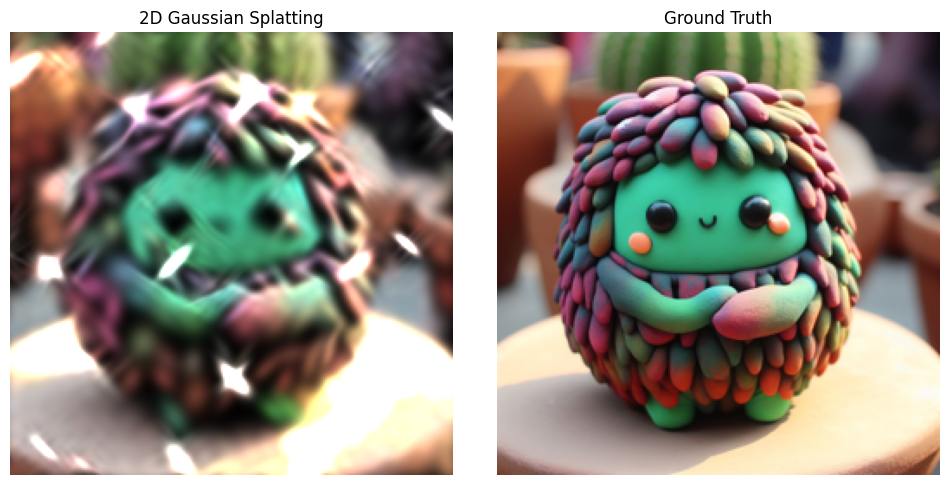

Epoch 101/2001, Loss: 0.08324487507343292, on 1000 points


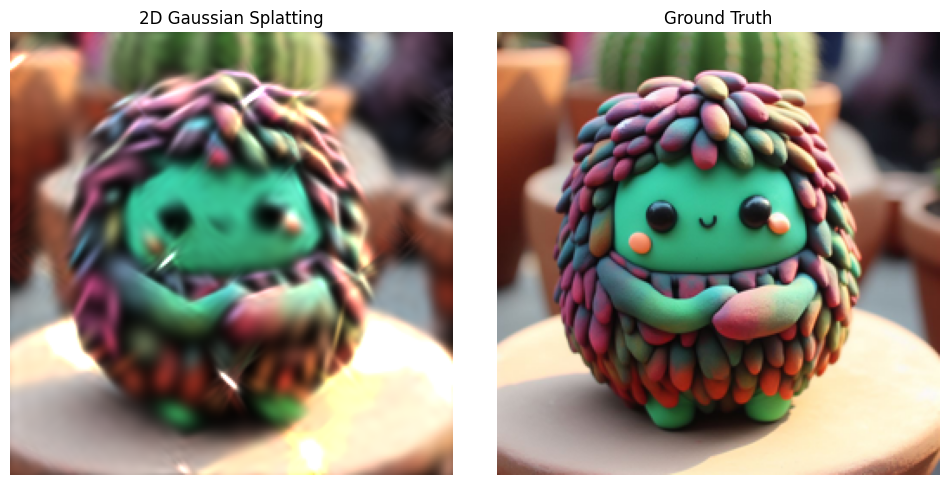

Epoch 201/2001, Loss: 0.046938590705394745, on 1000 points
number of splitted points: 183


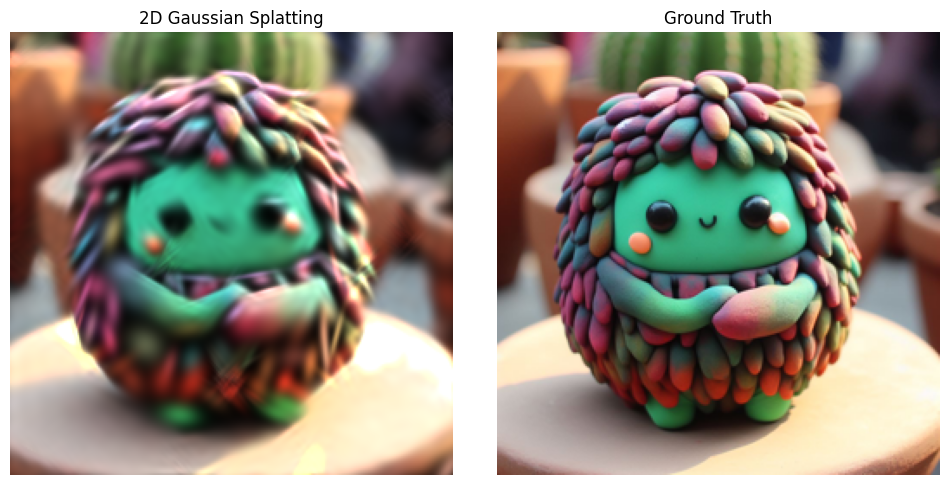

Epoch 301/2001, Loss: 0.03798918053507805, on 1000 points


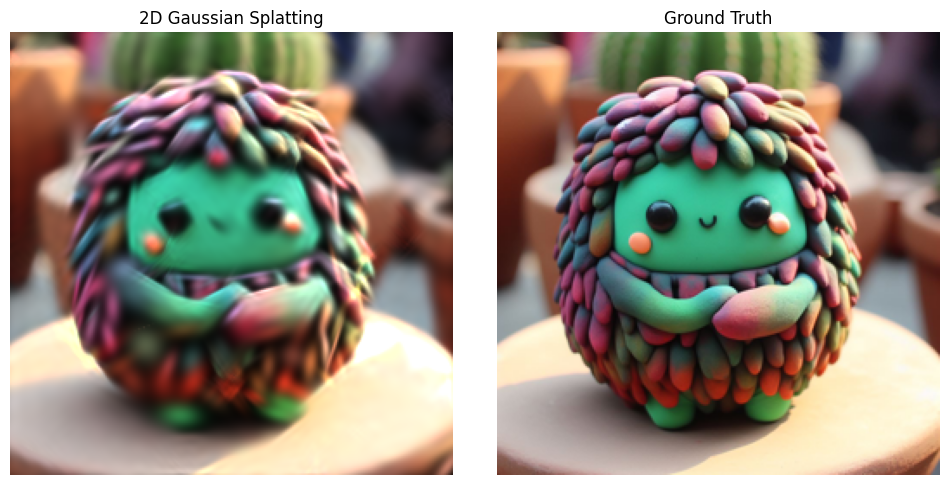

Epoch 401/2001, Loss: 0.0327923558652401, on 1183 points


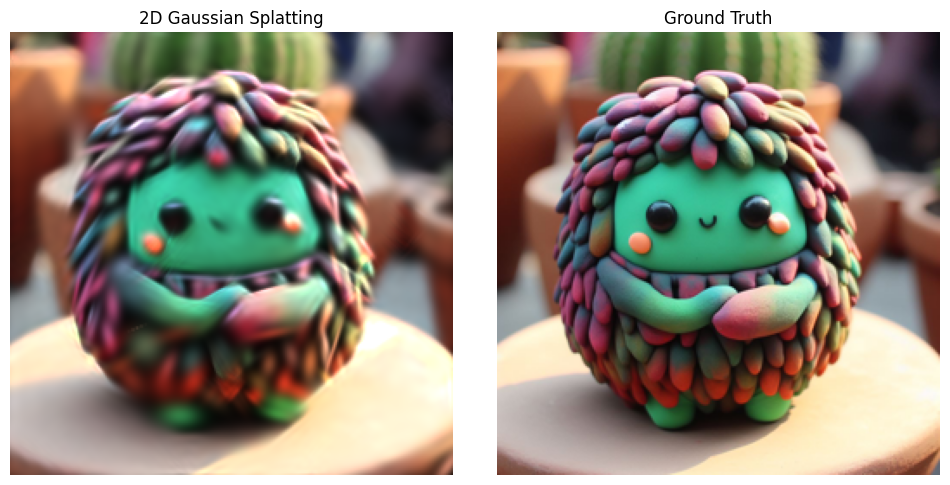

Epoch 501/2001, Loss: 0.029656855389475822, on 1183 points
number of splitted points: 247


In [12]:
for epoch in range(num_epochs):

    #find indices to remove and update the persistent mask
    if epoch % (densification_interval + 1) == 0 and epoch > 0:
        indices_to_remove = (torch.sigmoid(W[:, 3]) < 0.01).nonzero(as_tuple=True)[0]

        if len(indices_to_remove) > 0:
          print(f"number of pruned points: {len(indices_to_remove)}")

        persistent_mask[indices_to_remove] = False

        # Zero-out parameters and their gradients at every epoch using the persistent mask
        W.data[~persistent_mask] = 0.0


    gc.collect()
    torch.cuda.empty_cache()

    output = W[persistent_mask]

    batch_size = output.shape[0]

    sigma_x = torch.sigmoid(output[:, 0])
    sigma_y = torch.sigmoid(output[:, 1])
    rho = torch.tanh(output[:, 2])
    alpha = torch.sigmoid(output[:, 3])
    colours = torch.sigmoid(output[:, 4:7])
    pixel_coords = torch.tanh(output[:, 7:9])

    colours_with_alpha  = colours * alpha.view(batch_size, 1)
    g_tensor_batch = generate_2D_gaussian_splatting(KERNEL_SIZE, sigma_x, sigma_y, rho, pixel_coords, colours_with_alpha, image_size, device)
    loss = combined_loss(g_tensor_batch, target_tensor, lambda_param=0.2)

    optimizer.zero_grad()

    loss.backward()

    # Apply zeroing out of gradients at every epoch
    if persistent_mask is not None:
        W.grad.data[~persistent_mask] = 0.0

    if epoch % densification_interval == 0 and epoch > 0:

      # Calculate the norm of gradients
      gradient_norms = torch.norm(W.grad[persistent_mask][:, 7:9], dim=1, p=2)
      gaussian_norms = torch.norm(torch.sigmoid(W.data[persistent_mask][:, 0:2]), dim=1, p=2)

      sorted_grads, sorted_grads_indices = torch.sort(gradient_norms, descending=True)
      sorted_gauss, sorted_gauss_indices = torch.sort(gaussian_norms, descending=True)

      large_gradient_mask = (sorted_grads > grad_threshold)
      large_gradient_indices = sorted_grads_indices[large_gradient_mask]

      large_gauss_mask = (sorted_gauss > gauss_threshold)
      large_gauss_indices = sorted_gauss_indices[large_gauss_mask]

      common_indices_mask = torch.isin(large_gradient_indices, large_gauss_indices)
      common_indices = large_gradient_indices[common_indices_mask]
      distinct_indices = large_gradient_indices[~common_indices_mask]

      # Split points with large coordinate gradient and large gaussian values and descale their gaussian
      if len(common_indices) > 0:
        print(f"number of splitted points: {len(common_indices)}")
        start_index = current_marker + 1
        end_index = current_marker + 1 + len(common_indices)
        persistent_mask[start_index: end_index] = True
        W.data[start_index:end_index, :] = W.data[common_indices, :]
        scale_reduction_factor = 1.6
        W.data[start_index:end_index, 0:2] /= scale_reduction_factor
        W.data[common_indices, 0:2] /= scale_reduction_factor
        current_marker = current_marker + len(common_indices)

      # Clone it points with large coordinate gradient and small gaussian values
      if len(distinct_indices) > 0:

        print(f"number of cloned points: {len(distinct_indices)}")
        start_index = current_marker + 1
        end_index = current_marker + 1 + len(distinct_indices)
        persistent_mask[start_index: end_index] = True
        W.data[start_index:end_index, :] = W.data[distinct_indices, :]
        current_marker = current_marker + len(distinct_indices)

    optimizer.step()

    loss_history.append(loss.item())

    if epoch % display_interval == 0:
        num_subplots = 3 if display_loss else 2
        fig_size_width = 18 if display_loss else 12

        fig, ax = plt.subplots(1, num_subplots, figsize=(fig_size_width, 6))  # Adjust subplot to 1x3

        generated_array = g_tensor_batch.cpu().detach().numpy()

        ax[0].imshow(g_tensor_batch.cpu().detach().numpy())
        ax[0].set_title('2D Gaussian Splatting')
        ax[0].axis('off')

        ax[1].imshow(target_tensor.cpu().detach().numpy())
        ax[1].set_title('Ground Truth')
        ax[1].axis('off')

        if display_loss:
          ax[2].plot(range(epoch + 1), loss_history[:epoch + 1])
          ax[2].set_title('Loss vs. Epochs')
          ax[2].set_xlabel('Epoch')
          ax[2].set_ylabel('Loss')
          ax[2].set_xlim(0, num_epochs)  # Set x-axis limits

        # Display the image
        #plt.show(block=False)
        plt.subplots_adjust(wspace=0.1)  # Adjust this value to your preference
        plt.pause(0.1)  # Brief pause

        img = Image.fromarray((generated_array * 255).astype(np.uint8))

        # Create filename
        filename = f"{epoch}.jpg"

        # Construct the full file path
        file_path = os.path.join(directory, filename)

        # Save the image
        img.save(file_path)

        fig.savefig(file_path, bbox_inches='tight')

        plt.clf()  # Clear the current figure
        plt.close()  # Close the current figure

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, on {len(output)} points")




In [ ]:
image_files = []
for i in range(0, num_epochs, display_interval):
  image_files.append(f"{i}.jpg")

# Create a video writer object
writer = imageio.get_writer(os.path.join(directory, 'video.mp4'), fps=2)

# Add images to the video writer
for image_file in image_files:
    image_path = os.path.join(directory, image_file)
    image = imageio.imread(image_path)
    writer.append_data(image)

writer.close()

C:\Users\user\AppData\Local\Temp\ipykernel_15472\3940898492.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (950, 485) to (960, 496) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
